In [2]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.0f}'.format

In [3]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

In [4]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Individual'

tipo_modalidade = 'Seguradora'

## Leitura dos dados

In [5]:
path = f'D:/TCC/TCC/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

ans['ano'] = ans['ano'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

ans = ans[(ans['ano']>'2017') & (ans['ano']<'2022')]

ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26858 entries, 0 to 26857
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype        
---  ------         --------------  -----        
 0   ano            26858 non-null  period[A-DEC]
 1   cd_ops         26858 non-null  object       
 2   razao_social   26858 non-null  object       
 3   modalidade     26858 non-null  object       
 4   port_ops       26858 non-null  object       
 5   vigencia       26858 non-null  object       
 6   contratacao    26858 non-null  object       
 7   financiamento  26858 non-null  object       
 8   id_calendar    26858 non-null  object       
 9   trimestre      26858 non-null  period[Q-DEC]
 10  receita        26858 non-null  float64      
 11  despesa        26858 non-null  float64      
 12  benef          26858 non-null  float64      
 13  lg_cancelada   26858 non-null  object       
 14  lg_nova_ops    26858 non-null  object       
dtypes: float64(3), object(10), period[A-

In [32]:
ans_filt_resumo = ans_filt.groupby(['contratacao','port_ops','modalidade','ano'], as_index=False).agg({'cd_ops':lambda x: x.nunique(),
                                                                                                       'benef': 'sum',
                                                                                                       'receita':lambda x: sum_million(x),
                                                                                                       'despesa':lambda x: sum_million(x)})

ans_filt_resumo = ans_filt_resumo.sort_values(by=['contratacao','port_ops','cd_ops','ano','benef'],ascending=[True,True,False,True,False] ,ignore_index=True)

ans_filt_resumo = ans_filt_resumo.pivot(index = ['contratacao','port_ops','modalidade'], columns='ano', values=['cd_ops','benef','receita','despesa'])

ans_filt_resumo = pd.DataFrame(ans_filt_resumo.to_records())

ans_filt_resumo = ans_filt_resumo.rename({  ans_filt_resumo.columns[3]:'n_ops_2018',
                                            ans_filt_resumo.columns[4]:'n_ops_2019',
                                            ans_filt_resumo.columns[5]:'n_ops_2020',
                                            ans_filt_resumo.columns[6]:'n_ops_2021',
                                            ans_filt_resumo.columns[7]:'benef_2018',
                                            ans_filt_resumo.columns[8]:'benef_2019',
                                            ans_filt_resumo.columns[9]:'benef_2020',
                                            ans_filt_resumo.columns[10]:'benef_2021',
                                            ans_filt_resumo.columns[11]:'receita_2018',
                                            ans_filt_resumo.columns[12]:'receita_2019',
                                            ans_filt_resumo.columns[13]:'receita_2020',
                                            ans_filt_resumo.columns[14]:'receita_2021',
                                            ans_filt_resumo.columns[15]:'despesa_2018',
                                            ans_filt_resumo.columns[16]:'despesa_2019',
                                            ans_filt_resumo.columns[17]:'despesa_2020',
                                            ans_filt_resumo.columns[18]:'despesa_2021'}, axis=1)

display(ans_filt_resumo.head())

ans_filt_resumo.to_csv('ans_filt_resumo.csv',sep=';', index=False, encoding='mbcs', decimal=',')

,contratacao,port_ops,modalidade,n_ops_2018,n_ops_2019,n_ops_2020,n_ops_2021,benef_2018,benef_2019,benef_2020,benef_2021,receita_2018,receita_2019,receita_2020,receita_2021,despesa_2018,despesa_2019,despesa_2020,despesa_2021
0,Adesao,Grande,Cooperativa Médica,39,39,39,39,6593603,6743392,7407379,7225157,9406,10038,11358,12711,6323,7885,8464,10434
1,Adesao,Grande,Filantropia,2,2,2,2,93903,84816,73888,64711,61,62,60,57,44,47,39,44
2,Adesao,Grande,Medicina de Grupo,20,23,25,26,2969379,3202385,3620558,3974108,3111,3499,3458,4110,5035,3063,2084,3186
3,Adesao,Grande,Seguradora,3,3,3,3,1926169,1849534,1754961,1622277,5829,6247,6478,6237,4881,5332,5002,5687
4,Adesao,Médio,Autogestão,12,12,12,12,693129,660690,618394,617648,1256,1481,1456,1526,1151,1288,1109,1348


In [ ]:
ans_filt_ind_seg = ans_filt[(ans_filt['contratacao'] == tipo_contratacao) &((ans_filt['modalidade'] == tipo_modalidade))].reset_index(drop=True)

ans_filt_ind_seg = ans_filt_ind_seg[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

#ans_filt_ind_seg.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

In [11]:
ans_filt_ind_seg_agrup = ans_filt_ind_seg.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                             'despesa':lambda x: sum_million(x),
                                                                                             'benef': 'sum',
                                                                                             'cd_ops':lambda x: x.nunique()})

ans_filt_ind_seg_agrup['pct_despesa'] = ans_filt_ind_seg_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_ind_seg_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_ind_seg_agrup = ans_filt_ind_seg_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_ind_seg_agrup = ans_filt_ind_seg_agrup[(ans_filt_ind_seg_agrup.trimestre > '2017Q4') & (ans_filt_ind_seg_agrup.trimestre < '2022Q1')]

ans_filt_ind_seg_agrup[['n_ops','benef']] = ans_filt_ind_seg_agrup[['n_ops','benef']].astype('int')

ans_filt_ind_seg_agrup['trimestre'] = pd.PeriodIndex(ans_filt_ind_seg_agrup['trimestre'], freq="Q")

ans_filt_ind_seg_agrup.set_index('trimestre', inplace=True)

ans_filt_ind_seg_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,291.320,250.410,55593,5,85.960
2018Q2,300.340,277.630,54200,5,92.440
2018Q3,294.750,290.060,52992,5,98.410
2018Q4,313.810,282.560,51520,5,90.040
2019Q1,311.780,279.790,50264,5,89.740
2019Q2,312.280,285.860,49032,5,91.540
2019Q3,319.070,322.840,47820,5,101.180
2019Q4,329.070,303.230,46607,5,92.150
2020Q1,325.340,298.370,45612,5,91.710


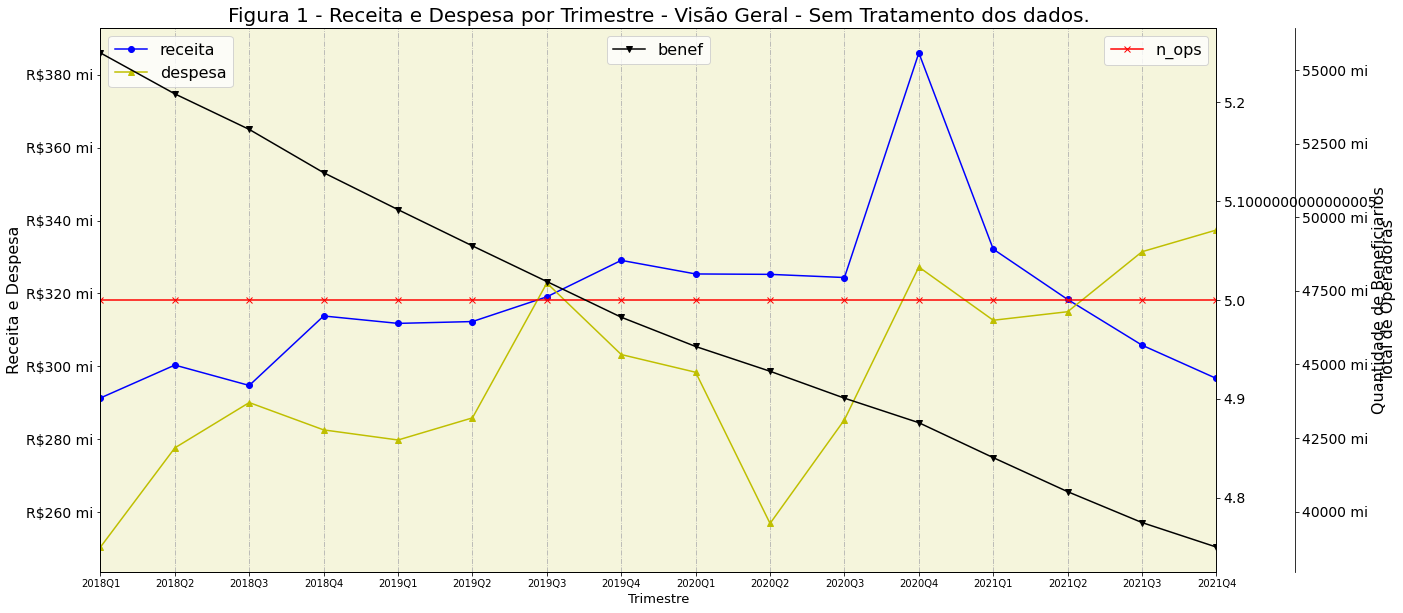

In [7]:
df_plot = ans_filt_ind_seg_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Visão Geral - Sem Tratamento dos dados.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

In [8]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_ind_seg_agrup_ops = ans_filt_ind_seg.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                         'despesa':lambda x: sum_million(x)})

ans_filt_ind_seg_agrup_ops.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_filt_ind_seg_agrup_ops.head()

,ano,cd_ops,trimestre,receita,despesa
4,2017,6246,2017Q3,384.920,370.990
2,2017,5711,2017Q3,346.720,343.740
5,2017,6246,2017Q4,133.940,133.410
3,2017,5711,2017Q4,124.860,112.000
0,2017,477,2017Q3,38.010,42.950


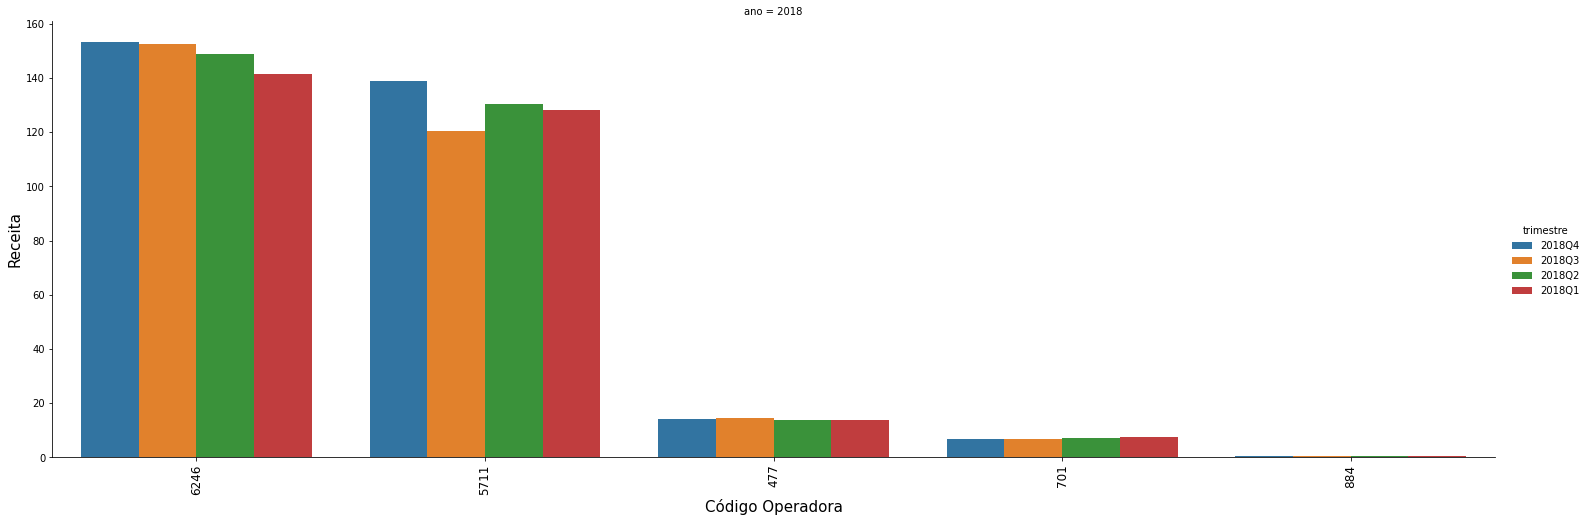

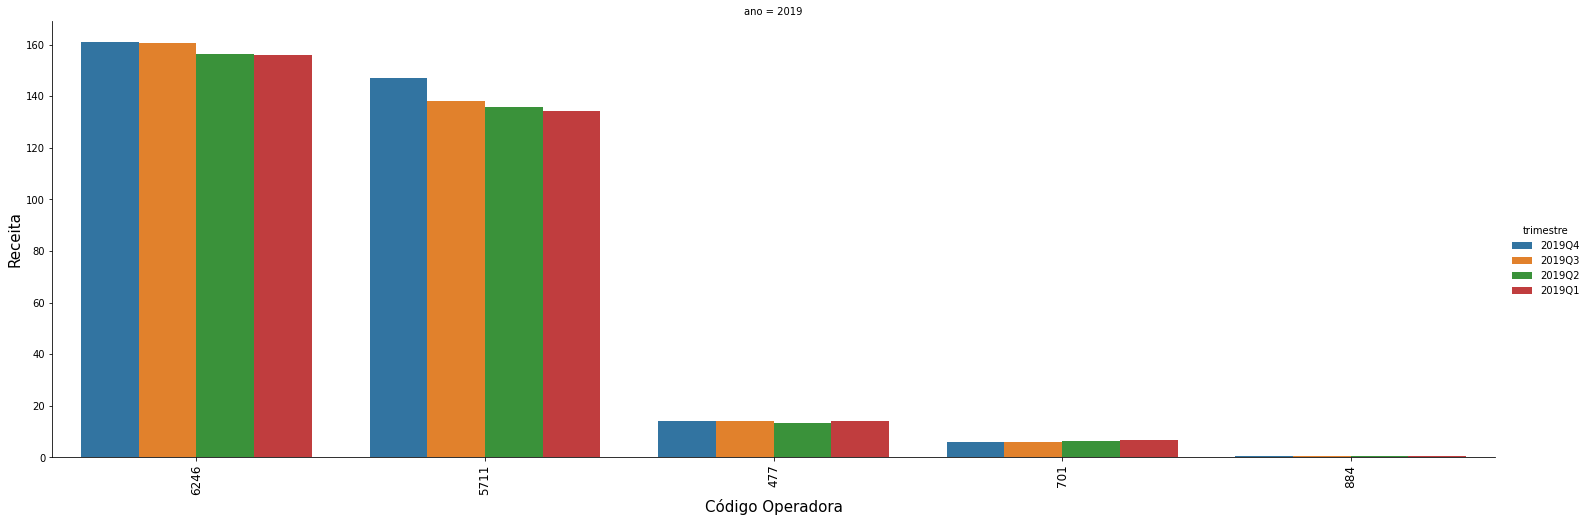

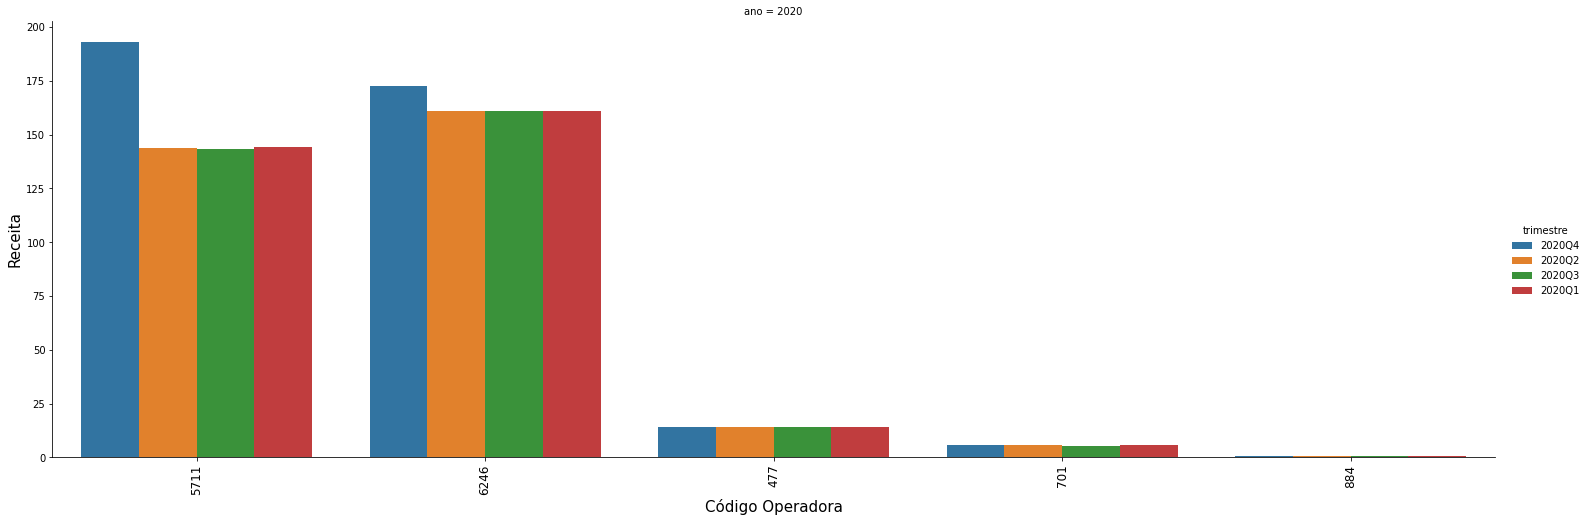

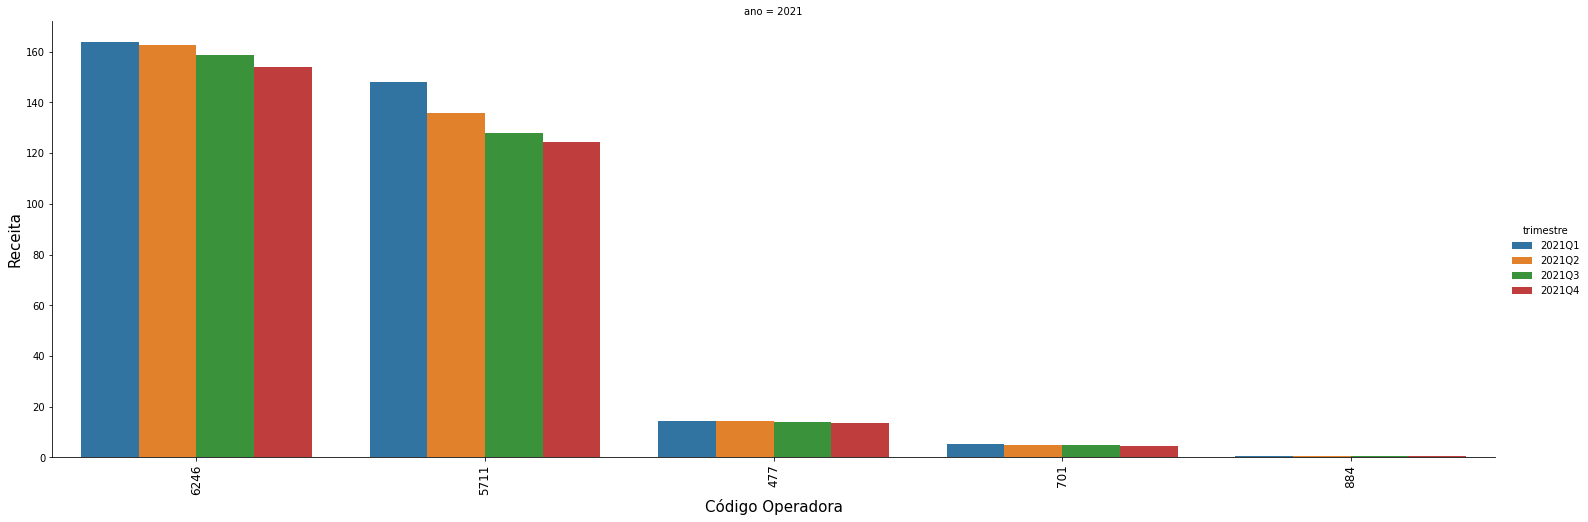

In [9]:
df_plot = ans_filt_ind_seg_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

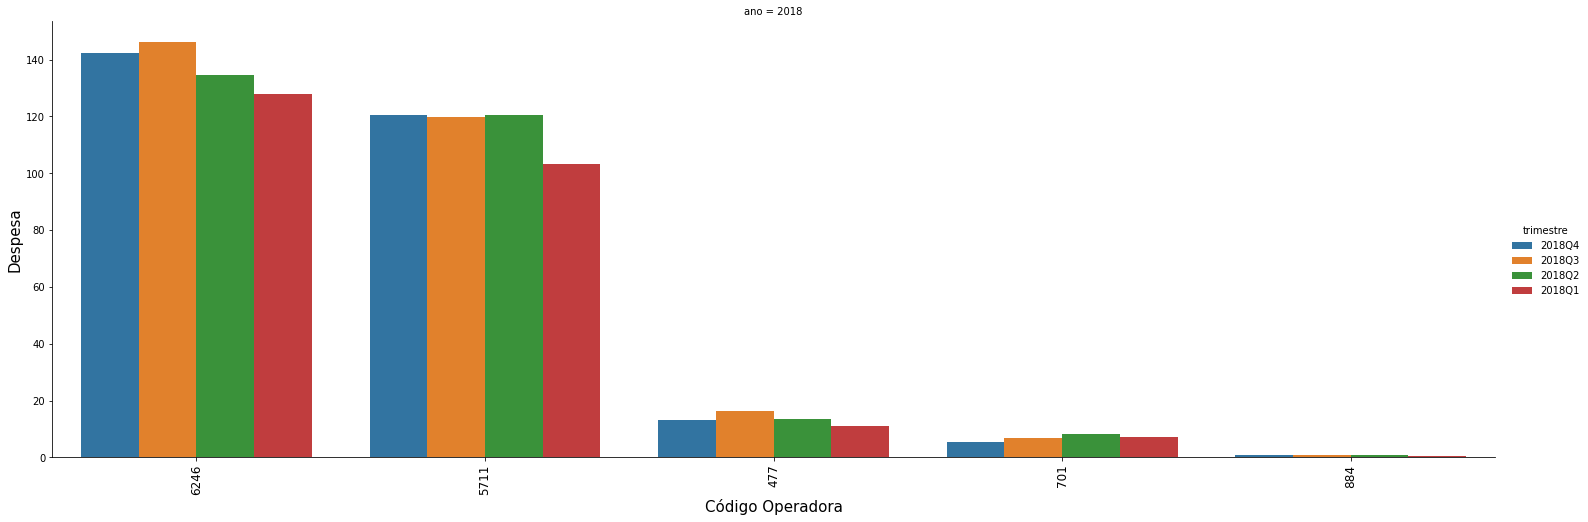

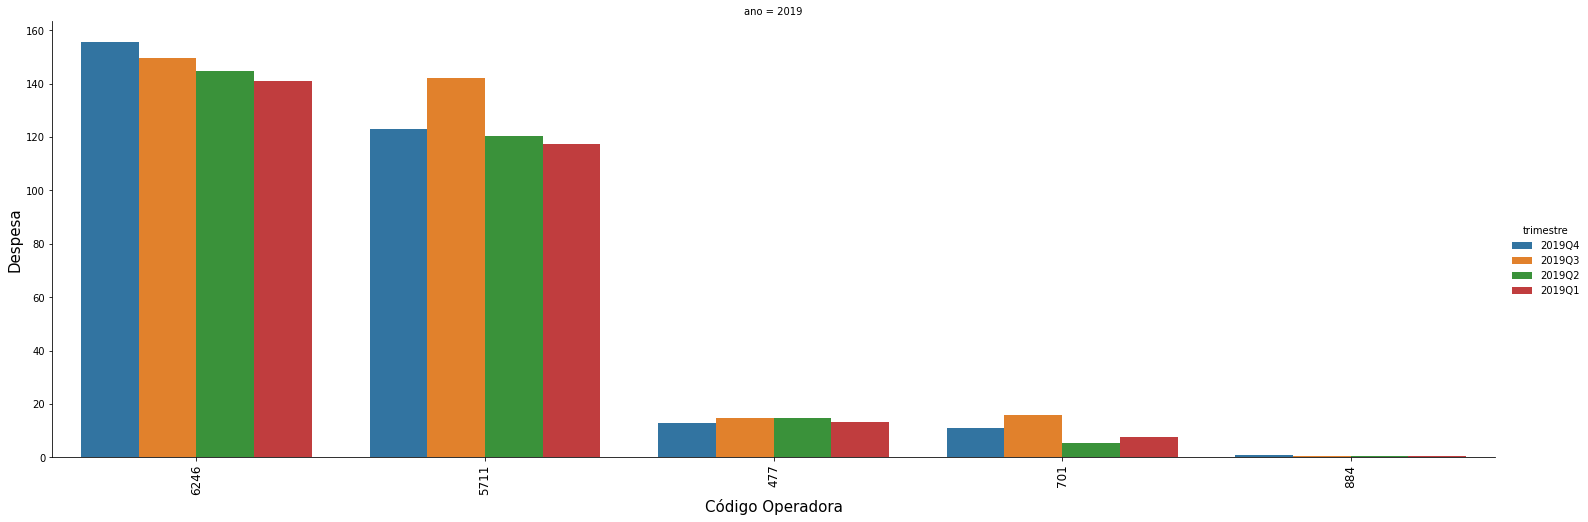

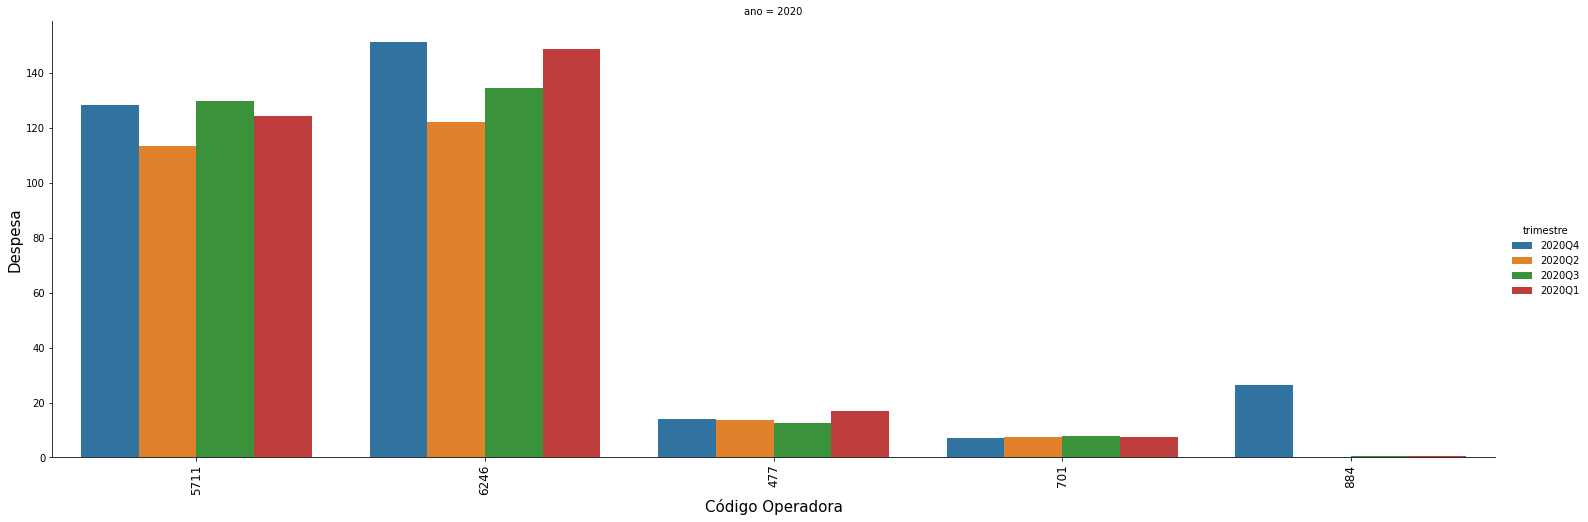

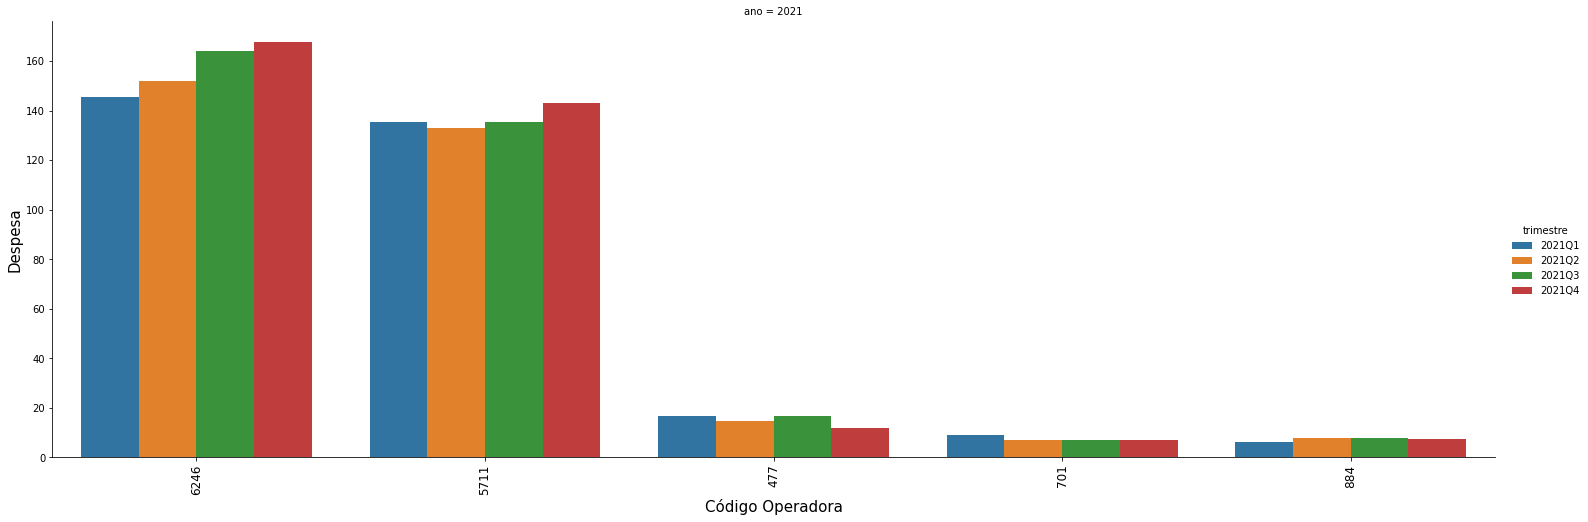

In [10]:
df_plot = ans_filt_ind_seg_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()